In [ ]:
!pip install pychattr
!pip install marketing_attribution_models

In [2]:
import pandas as pd
import numpy as np
from pychattr.channel_attribution import MarkovModel
from pychattr.channel_attribution import HeuristicModel
from marketing_attribution_models import MAM
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#reading attribution data from public google sheet url and displaying first 5 rows
attribution_data = "https://docs.google.com/spreadsheets/d/1-FJE5ziP90P-d_Y2SS88Zeaq1Al7-9Say3Vs_1uOzCQ/export?format=csv"
df = pd.read_csv(attribution_data)

In [17]:
#creating a new normally distributed variable conversion cost, for each conversion, by assigning mean and standard deviation to each channel and creating values around them
channel_cost_factors = {
    'Instagram': {'mean': 0.1, 'std': 0.02}, 'Online Display': {'mean': 0.08, 'std': 0.01}, 'Paid Search': {'mean': 0.12, 'std': 0.03},
    'Facebook': {'mean': 0.09, 'std': 0.02}, 'Online Video': {'mean': 0.07, 'std': 0.01}}

df['conversion_cost'] = df.apply(lambda row: max(0, np.random.normal(row['conversion_value'] * channel_cost_factors[row['channel']]['mean'],
                          row['conversion_value'] * channel_cost_factors[row['channel']]['std'])) if row['channel'] in channel_cost_factors and row['conversion'] == 1 else 0.0, axis=1)

df.head()

,cookie,time,interaction,conversion,conversion_value,channel,conversion_cost,chronology
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram,0.0,4
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display,0.0,3
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display,0.0,2
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display,0.0,1
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search,0.0,6


In [5]:
# defining pychatter plot function
def delimeterformat(df):
    str1 = ""
    for i in df['path']:
        str1 += i + ' > '
    return str1[:-3]

In [6]:
# grouping by cookie to identify the chronology of advert exposure per user
df['chronology'] = df.sort_values(by='time', ascending=False).groupby(['cookie']).cumcount()+1
# creating advert exposure journey paths per customer
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index().rename(columns={"channel": "path"})
# verifying whether individual customer last channel advert exposure led to conversion or not and value of conversion
df_lastexp = df.sort_values(by=['time', 'cookie','conversion'], ascending=True).drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_cost', 'conversion_value']]
# merging last exposure conversion to advert exposure journey paths
df_paths = pd.merge(df_paths, df_lastexp, on='cookie', how='left')
#duplicating paths dataframe for shapely model
df_path = df_paths.copy()
# applying delimeter
df_paths['path'] = df_paths.apply(delimeterformat, axis=1)
# creating null column to indiccate if a channel path did not lead to conversion
df_paths['null'] = df_paths['conversion'].apply(lambda x: 0 if x == 1 else 1)
df_paths.drop(columns = 'cookie', inplace = True)
# grouping df_paths by individual paths to see how many times a path led to conversion and not
attribution_df = df_paths.groupby(['path'], as_index = False).sum().rename(columns={"conversion": "total_conversions", "null": "total_null"})


In [18]:
# duplicating the attribution dataframe for calculating heuristic, and data driven models
attribution_dfH = attribution_df.copy()
attribution_dfM = attribution_df.copy()
attribution_df.sample(5)

,path,total_conversions,conversion_cost,conversion_value,total_null
807,Facebook > Facebook > Facebook > Instagram > F...,1,0.805157,8.0,0
9566,Paid Search > Facebook > Paid Search > Online ...,0,0.000000,0.0,1
10327,Paid Search > Paid Search > Facebook > Instagr...,0,0.000000,0.0,1
3927,Facebook > Paid Search > Paid Search > Instagram,2,1.209786,14.0,28
3111,Facebook > Instagram > Paid Search > Facebook ...,0,0.000000,0.0,1


In [8]:
# instantiating Heuristic model
hm = HeuristicModel(path_feature="path", conversion_feature="total_conversions", null_feature="total_null",
                    revenue_feature="conversion_value", cost_feature="conversion_cost", separator=">", first_touch=True,
                    last_touch=True, linear_touch=True, ensemble_results=False)

# fit the model
hm.fit(attribution_dfH)

# view the heuristic results
df_hms = hm.attribution_model_.sort_values(by='linear_touch_conversions', ascending=False).reset_index(drop=True).rename(columns={'channel':'channel_name'})
df_hms

,channel_name,first_touch_conversions,first_touch_revenue,first_touch_cost,last_touch_conversions,last_touch_revenue,last_touch_cost,linear_touch_conversions,linear_touch_revenue,linear_touch_cost
0,Facebook,5177.0,32283.0,2974.586054,5301.0,33143.5,1162.189872,5218.903371,32614.300094,2983.261613
1,Paid Search,4757.0,29724.0,3368.469832,4547.0,28331.5,1778.555403,4681.198650,29194.458588,3381.017293
2,Online Video,3216.0,20225.5,1470.012747,3408.0,21418.0,452.202715,3349.403371,21045.330408,1510.997977
3,Instagram,2329.0,14579.5,1390.776983,2244.0,14039.5,568.138178,2265.179353,14171.723842,1372.316046
4,Online Display,2160.0,13419.0,1140.314480,2139.0,13298.5,524.942169,2124.315256,13205.187068,1096.567167


In [9]:
# instantiating Markov model
mm = MarkovModel(path_feature="path", conversion_feature="total_conversions", null_feature="total_null",
                 revenue_feature="conversion_value", cost_feature="conversion_cost", separator=">", k_order=1, n_simulations=10000,
                 max_steps=None, return_transition_probs=True, random_state=12)

# fit the model
mm.fit(attribution_dfM)
# view the simulation results
df_mms = mm.attribution_model_.sort_values(by='total_conversions', ascending=False).reset_index(drop=True).rename(columns={'total_conversions':'markov_conversion', 'total_revenue':'markov_revenue'})
df_mms

,channel_name,markov_conversion,markov_revenue
0,Facebook,5291.700,33079.323245
1,Paid Search,4762.530,29744.214170
2,Instagram,2857.518,17823.560043
3,Online Video,2769.323,17380.848859
4,Online Display,1957.929,12203.053683


In [10]:
# view the removal effects
df_mmsr = mm.removal_effects_.sort_values(by='removal_effect', ascending=False).reset_index(drop=True)
df_mmsr

,channel_name,removal_effect,removal_effect_value
0,Facebook,0.413223,0.413678
1,Paid Search,0.371901,0.371970
2,Instagram,0.223140,0.222895
3,Online Video,0.216253,0.217359
4,Online Display,0.152893,0.152607


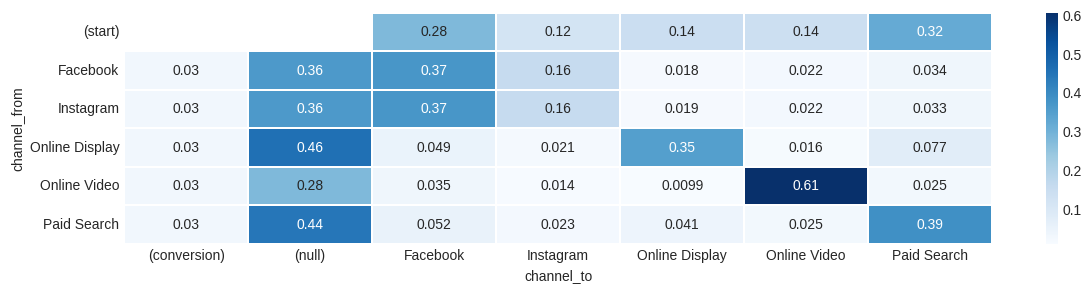

In [11]:
# transition matrix
matrix = mm.transition_matrix_
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'], columns=['channel_to'], aggfunc=np.sum)
plt.figure(figsize=(14,3))
sns.heatmap(matrix, cmap="Blues", annot=True, linewidths=0.1)
plt.show()

In [12]:
 #'conversion_cost', 'conversion_value'  +  agg({'cookie':'count', 'conversion_cost':'sum', 'conversion_value':'sum'}) +  'conversion_cost':'total_cost', 'conversion_value':'total_revenue'
att_df = df[['channel', 'cookie', 'conversion_cost',]].groupby(['channel'], as_index = False).agg({'cookie':'count', 'conversion_cost':'sum'}).rename(columns={'channel':'channel_name', 'cookie':'traffic', 'conversion_cost':'total_cost'})
att_df = att_df.merge(df_hms, on='channel_name', how='left').merge(df_mms, on='channel_name', how='left').merge(df_mmsr, on='channel_name', how='left')
att_df

,channel_name,traffic,total_cost,first_touch_conversions,first_touch_revenue,first_touch_cost,last_touch_conversions,last_touch_revenue,last_touch_cost,linear_touch_conversions,linear_touch_revenue,linear_touch_cost,markov_conversion,markov_revenue,removal_effect,removal_effect_value
0,Facebook,175741,2986.465579,5177.0,32283.0,2974.586054,5301.0,33143.5,1162.189872,5218.903371,32614.300094,2983.261613,5291.700,33079.323245,0.413223,0.413678
1,Instagram,75201,1404.315663,2329.0,14579.5,1390.776983,2244.0,14039.5,568.138178,2265.179353,14171.723842,1372.316046,2857.518,17823.560043,0.223140,0.222895
2,Online Display,71053,1066.731683,2160.0,13419.0,1140.314480,2139.0,13298.5,524.942169,2124.315256,13205.187068,1096.567167,1957.929,12203.053683,0.152893,0.152607
3,Online Video,113302,1494.542258,3216.0,20225.5,1470.012747,3408.0,21418.0,452.202715,3349.403371,21045.330408,1510.997977,2769.323,17380.848859,0.216253,0.217359
4,Paid Search,151440,3392.104913,4757.0,29724.0,3368.469832,4547.0,28331.5,1778.555403,4681.198650,29194.458588,3381.017293,4762.530,29744.214170,0.371901,0.371970


In [13]:
import gspread
from google.colab import auth
auth.authenticate_user()
from google.auth import default
creds, _= default()
gc = gspread.authorize(creds)
from gspread_dataframe import set_with_dataframe

In [14]:
worksheet = gc.open('Portfolio_data')
worksheet = worksheet.worksheet('attribution data')
worksheet.clear()
set_with_dataframe(worksheet, att_df)

worksheet = gc.open('Portfolio_data')
worksheet = worksheet.worksheet('attribution confusion matrix')
worksheet.clear()
set_with_dataframe(worksheet, mm.transition_matrix_, include_index = True, include_column_header=True)

*Function for eas of use*

In [15]:
## model function
def attribution_model(df):
    def delimeterformat(df):
        str1 = ""
        for i in df['path']:
            str1 += i + ' > '
        return str1[:-3]

    # grouping by cookie to identify the chronology of advert exposure per user
    df['chronology'] = df.sort_values(by='time', ascending=False).groupby(['cookie']).cumcount()+1
    # creating advert exposure journey paths per customer
    df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index().rename(columns={"channel": "path"})
    # verifying whether individual customer last channel advert exposure led to conversion or not and value of conversion
    df_lastexp = df.sort_values(by=['time', 'cookie','conversion'], ascending=True).drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_cost', 'conversion_value']]
    # merging last exposure conversion to advert exposure journey paths
    df_paths = pd.merge(df_paths, df_lastexp, on='cookie', how='left')
    # duplicating paths dataframe for shapely model
    df_path = df_paths.copy()
    # applying delimeter
    df_paths['path'] = df_paths.apply(delimeterformat, axis=1)
    # creating null column to indicate if a channel path did not lead to conversion
    df_paths['null'] = df_paths['conversion'].apply(lambda x: 0 if x == 1 else 1)
    df_paths.drop(columns = 'cookie', inplace = True)
    # grouping df_paths by individual paths to see how many times a path led to conversion and not
    attribution_df = df_paths.groupby(['path'], as_index = False).sum().rename(columns={"conversion": "total_conversions", "null": "total_null"})
    # duplicating the attribution dataframe for calculating heuristic, and data driven models
    attribution_dfH = attribution_df.copy()
    attribution_dfM = attribution_df.copy()

    # instantiating Heuristic model
    hm = HeuristicModel(path_feature="path", conversion_feature="total_conversions", null_feature="total_null",
                        revenue_feature="conversion_value", cost_feature="conversion_cost", separator=">", first_touch=True,
                        last_touch=True, linear_touch=True, ensemble_results=False)
    # fit the model
    hm.fit(attribution_dfH)
    # view the heuristic results
    df_hms = hm.attribution_model_.sort_values(by='linear_touch_conversions', ascending=False).reset_index(drop=True).rename(columns={'channel':'channel_name'})

    # instantiating Markov model
    mm = MarkovModel(path_feature="path", conversion_feature="total_conversions", null_feature="total_null",
                     revenue_feature="conversion_value", cost_feature="conversion_cost", separator=">", k_order=1, n_simulations=10000,
                     max_steps=None, return_transition_probs=True, random_state=12)
    # fit the model
    mm.fit(attribution_dfM)
    # view the simulation results
    df_mms = mm.attribution_model_.sort_values(by='total_conversions', ascending=False).reset_index(drop=True).rename(columns={'total_conversions':'markov_conversion', 'total_revenue':'markov_revenue'})
    # view the removal effects
    df_mmsr = mm.removal_effects_.sort_values(by='removal_effect', ascending=False).reset_index(drop=True)

    #'conversion_cost', 'conversion_value'  +  agg({'cookie':'count', 'conversion_cost':'sum', 'conversion_value':'sum'}) +  'conversion_cost':'total_cost', 'conversion_value':'total_revenue'
    att_df = df[['channel', 'cookie', 'conversion_cost',]].groupby(['channel'], as_index = False).agg({'cookie':'count', 'conversion_cost':'sum'}).rename(columns={'channel':'channel_name', 'cookie':'traffic', 'conversion_cost':'total_cost'})
    att_df = att_df.merge(df_hms, on='channel_name', how='left').merge(df_mms, on='channel_name', how='left').merge(df_mmsr, on='channel_name', how='left')

    # transition matrix
    matrix = mm.transition_matrix_
    matrix_v = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'], columns=['channel_to'], aggfunc=np.sum)
    plt.figure(figsize=(14,3))
    sns.heatmap(matrix_v, cmap="Blues", annot=True, linewidths=0.1)
    plt.show()

    return att_df, matrix_v


[link to dashboard](https://lookerstudio.google.com/u/0/reporting/b7f7aeae-c645-4a80-9b3a-03b01b95c7f6/page/p_yg2oanlbid/)